#**Deep Learning Course Project - Gesture Recognition**

Project by : Prasad Maharana


### Problem Statement
Imagine you are working as a data scientist at a home electronics company which manufactures state of the art smart televisions. You want to develop a cool feature in the smart-TV that can recognise five different gestures performed by the user which will help users control the TV without using a remote.

The gestures are continuously monitored by the webcam mounted on the TV. Each gesture corresponds to a specific command:
 
* Thumbs Up -   Increase the volume. 
* Thumbs Down - Decrease the volume. 
* Left Swipe - 'Jump' backwards 10 seconds. 
* Right Swipe -'Jump' forward 10 seconds.  
* Stop -        Pause the movie. 

Each video is a sequence of 30 frames (or images).


In [ ]:
## Checking the GPU configuration

!nvidia-smi

Tue Feb  8 19:38:25 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 471.11       Driver Version: 471.11       CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:26:00.0  On |                  N/A |
| 35%   39C    P8    11W / 120W |    573MiB /  6144MiB |     13%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
#Scipy 1.1.0 has been installed for using imread and imresize
#!pip install scipy==1.1.0

  Using cached scipy-1.1.0-cp37-none-win_amd64.whl (30.9 MB)
  Attempting uninstall: scipy
    Found existing installation: scipy 1.4.1
    Uninstalling scipy-1.4.1:
      Successfully uninstalled scipy-1.4.1


ERROR: Could not install packages due to an OSError: [WinError 5] Access is denied: 'C:\\Users\\PRASAD~1\\AppData\\Local\\Temp\\pip-uninstall-zg8bz5zp\\_lib\\_ccallback_c.cp37-win_amd64.pyd'
Consider using the `--user` option or check the permissions.



In [ ]:
# Importing the necessary libraries

import numpy as np
import os
from scipy.misc import imread, imresize
import datetime
import os
import warnings
warnings.filterwarnings("ignore")
import abc
from sys import getsizeof

We set the random seed so that the results don't vary drastically.

In [ ]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.random.set_seed(30)
#tf.random.set_seed

Using TensorFlow backend.


In [ ]:
#install opencv and use cv2
!pip install opencv-python


In [ ]:
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [ ]:
# importing some other libraries which will be needed for model building.

from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation
from keras.layers.convolutional import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D
from keras.layers.recurrent import LSTM
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras import optimizers
from keras.layers import Dropout

In [ ]:
project_folder=r'C:\Users\Prasad_Maharana/Desktop/Gesture Recognition/'

###Plotting

In [ ]:
# function to plot the training/validation accuracies/losses.

def plot(history):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
    axes[0].plot(history.history['loss'])   
    axes[0].plot(history.history['val_loss'])
    axes[0].legend(['loss','val_loss'])

    axes[1].plot(history.history['categorical_accuracy'])   
    axes[1].plot(history.history['val_categorical_accuracy'])
    axes[1].legend(['categorical_accuracy','val_categorical_accuracy'])

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [ ]:
class ModelBuilder(metaclass= abc.ABCMeta):
    # initialisng the path where project data resides
    def initialize_path(self,project_folder):
        self.train_doc = np.random.permutation(open(project_folder + '/' + 'train.csv').readlines())
        self.val_doc = np.random.permutation(open(project_folder + '/' + 'val.csv').readlines())
        self.train_path = project_folder + '/' + 'train'
        self.val_path =  project_folder + '/' + 'val'
        self.num_train_sequences = len(self.train_doc)
        self.num_val_sequences = len(self.val_doc)
    # initialising the image properties    
    def initialize_image_properties(self,image_height=100,image_width=100):
        self.image_height=image_height
        self.image_width=image_width
        self.channels=3
        self.num_classes=5
        self.total_frames=30
    # initialising the batch size, frames to sample and the no. of epochs
    def initialize_hyperparams(self,frames_to_sample=30,batch_size=20,num_epochs=20):
        self.frames_to_sample=frames_to_sample
        self.batch_size=batch_size
        self.num_epochs=num_epochs
        
    # MOST IMPORTANT PART HERE - The generator function        
    def generator(self,source_path, folder_list, augment=False):
        img_idx = np.round(np.linspace(0,self.total_frames-1,self.frames_to_sample)).astype(int)
        batch_size=self.batch_size
        while True:
            t = np.random.permutation(folder_list)
            num_batches = len(t)//batch_size
        
            for batch in range(num_batches): 
                batch_data, batch_labels= self.one_batch_data(source_path,t,batch,batch_size,img_idx,augment)
                yield batch_data, batch_labels 

            remaining_seq=len(t)%batch_size
        
            if (remaining_seq != 0):
                batch_data, batch_labels= self.one_batch_data(source_path,t,num_batches,batch_size,img_idx,augment,remaining_seq)
                yield batch_data, batch_labels 
    
    
    def one_batch_data(self,source_path,t,batch,batch_size,img_idx,augment,remaining_seq=0):
    
        seq_len = remaining_seq if remaining_seq else batch_size
    
        batch_data = np.zeros((seq_len,len(img_idx),self.image_height,self.image_width,self.channels)) 
        batch_labels = np.zeros((seq_len,self.num_classes)) 
    
        if (augment): batch_data_aug = np.zeros((seq_len,len(img_idx),self.image_height,self.image_width,self.channels))

        
        for folder in range(seq_len): 
            imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) 
            for idx,item in enumerate(img_idx):
                #performing image reading and resizing
                image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                image_resized=imresize(image,(self.image_height,self.image_width,3))
            
                #normalizing the images
                batch_data[folder,idx,:,:,0] = (image_resized[:,:,0])/255
                batch_data[folder,idx,:,:,1] = (image_resized[:,:,1])/255
                batch_data[folder,idx,:,:,2] = (image_resized[:,:,2])/255
            
                if (augment):
                    shifted = cv2.warpAffine(image, 
                                             np.float32([[1, 0, np.random.randint(-30,30)],[0, 1, np.random.randint(-30,30)]]), 
                                            (image.shape[1], image.shape[0]))
                    
                    gray = cv2.cvtColor(shifted,cv2.COLOR_BGR2GRAY)

                    x0, y0 = np.argwhere(gray > 0).min(axis=0)
                    x1, y1 = np.argwhere(gray > 0).max(axis=0) 
                    # cropping the images to have the targeted gestures and remove the noise from the images.
                    cropped=shifted[x0:x1,y0:y1,:]
                    
                    image_resized=imresize(cropped,(self.image_height,self.image_width,3))
                    
                    #shifted = cv2.warpAffine(image_resized, 
                    #                        np.float32([[1, 0, np.random.randint(-3,3)],[0, 1, np.random.randint(-3,3)]]), 
                    #                        (image_resized.shape[1], image_resized.shape[0]))
            
                    batch_data_aug[folder,idx,:,:,0] = (image_resized[:,:,0])/255
                    batch_data_aug[folder,idx,:,:,1] = (image_resized[:,:,1])/255
                    batch_data_aug[folder,idx,:,:,2] = (image_resized[:,:,2])/255
                
            
            batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            
    
        if (augment):
            batch_data=np.concatenate([batch_data,batch_data_aug])
            batch_labels=np.concatenate([batch_labels,batch_labels])

        
        return(batch_data,batch_labels)
    
    
    def train_model(self, model, augment_data=False):
        train_generator = self.generator(self.train_path, self.train_doc,augment=augment_data)
        val_generator = self.generator(self.val_path, self.val_doc)

        model_name = 'model_init' + '_' + str(datetime.datetime.now()).replace(' ','').replace(':','_') + '/'
    
        if not os.path.exists(model_name):
            os.mkdir(model_name)
        
        filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

        checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
        LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)
        
        earlystop = EarlyStopping( monitor="val_loss", min_delta=0,patience=10,verbose=1)
        callbacks_list = [checkpoint, LR, earlystop]

        if (self.num_train_sequences%self.batch_size) == 0:
            steps_per_epoch = int(self.num_train_sequences/self.batch_size)
        else:
            steps_per_epoch = (self.num_train_sequences//self.batch_size) + 1

        if (self.num_val_sequences%self.batch_size) == 0:
            validation_steps = int(self.num_val_sequences/self.batch_size)
        else:
            validation_steps = (self.num_val_sequences//self.batch_size) + 1
    
        history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=self.num_epochs, verbose=1, 
                            callbacks=callbacks_list, validation_data=val_generator, 
                            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
        return history

        
    @abc.abstractmethod
    def define_model(self):
        pass

## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

## Sample Model

In [ ]:
class ModelConv3D1(ModelBuilder):
    
    def define_model(self):

        model =Sequential()
        model.add(Conv3D(16, (3, 3, 3), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(128,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))

        model.add(Dense(64,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.25))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam()
        #optimiser = 'sgd'
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [ ]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=160,image_width=160)
conv_3d1.initialize_hyperparams(frames_to_sample=30,batch_size=10,num_epochs=1)
conv_3d1_model=conv_3d1.define_model()
conv_3d1_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 30, 160, 160, 16)  1312      
_________________________________________________________________
activation_1 (Activation)    (None, 30, 160, 160, 16)  0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 30, 160, 160, 16)  64        
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 15, 80, 80, 16)    0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 15, 80, 80, 32)    4128      
_________________________________________________________________
activation_2 (Activation)    (None, 15, 80, 80, 32)    0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 15, 80, 80, 32)   

##### Sample Cropping

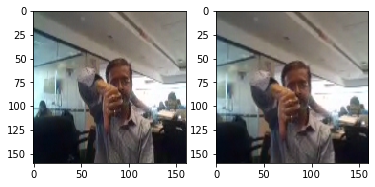

In [ ]:
test_generator=ModelConv3D1()
test_generator.initialize_path(project_folder)
test_generator.initialize_image_properties(image_height=160,image_width=160)
test_generator.initialize_hyperparams(frames_to_sample=30,batch_size=3,num_epochs=1)

g=test_generator.generator(test_generator.val_path,test_generator.val_doc,augment=True)
batch_data, batch_labels=next(g)
fig, axes = plt.subplots(nrows=1, ncols=2)
axes[0].imshow(batch_data[0,15,:,:,:])   
axes[1].imshow(batch_data[3,15,:,:,:])   

###Experimentation
Experimenting with Image resolution, number of frames to use and batch_size

In [ ]:
conv_3d1.train_model(conv_3d1_model)

Epoch 1/1
67/67 [==============================] - 151s 2s/step - loss: 1.5001 - categorical_accuracy: 0.4193 - val_loss: 2.6216 - val_categorical_accuracy: 0.1600

Epoch 00001: val_loss improved from inf to 2.62157, saving model to model_init_2022-02-0714_00_57.748240/model-00001-1.48369-0.41931-2.62157-0.16000.h5


###Observation
The training time is being affected by the image resolution, number of images in a  batch sequence and batch size. On the ablation experiment, we can see the training_score of 41% and vaidation_score of 16%.

So lets trade-off between these parameters

##Experimentation to test training time

Below are the experiments to see how training time is affected by image resolution, number of images in sequence and batch size

Reducing Image size to 100 x 100 and batch size 30

In [ ]:
#Experiment 1
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=100,image_width=100)
conv_3d1.initialize_hyperparams(frames_to_sample=15,batch_size=30,num_epochs=2)
conv_3d1_model=conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

ValueError: ignored

**Observation:**
We are getting a Negative dimension error on the reducing the image size since the Pooling kernal configuration changes

Reducing Image size to 100 x 100 and batch size 20

In [ ]:
#Experiment 2
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=100,image_width=100)
conv_3d1.initialize_hyperparams(frames_to_sample=30,batch_size=20,num_epochs=2)
conv_3d1_model=conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Total Params: 687813
Epoch 1/2
34/34 [==============================] - 102s 3s/step - loss: 1.4548 - categorical_accuracy: 0.4585 - val_loss: 2.8525 - val_categorical_accuracy: 0.1600

Epoch 00001: val_loss improved from inf to 2.85246, saving model to model_init_2022-02-0714_11_51.933277/model-00001-1.47149-0.45852-2.85246-0.16000.h5
Epoch 2/2
34/34 [==============================] - 106s 3s/step - loss: 0.9900 - categorical_accuracy: 0.6501 - val_loss: 4.9622 - val_categorical_accuracy: 0.1500

Epoch 00002: val_loss did not improve from 2.85246


**Observation:** 

On reducing the image size to 100 x 100, and frame sampling to 30 with batch size reduction to 20, we can see a train score of 65% and val score of 15% which is definitely overfitting

In [ ]:
#Experiment 3
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=160,image_width=160)
conv_3d1.initialize_hyperparams(frames_to_sample=30,batch_size=15,num_epochs=2)
conv_3d1_model=conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Total Params: 1736389
Epoch 1/2


ResourceExhaustedError: ignored

**Observation:**

We hit a resource exhausted error when we increased the image size to 160 x 160 and batch size of 15 with frame sampling of 30

In [ ]:
#Experiment 4
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=160,image_width=160)
conv_3d1.initialize_hyperparams(frames_to_sample=16,batch_size=30,num_epochs=2)
conv_3d1_model=conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Total Params: 1736389
Epoch 1/2


ResourceExhaustedError: ignored

**Observation**: 

We again hit a resource exhausted error when we increased the image size to 160 x 160 and batch size of 15 with frame sampling of 30



####Inference:
- As we see from the above experiments 
* **image resolution**
* **number of frames** in sequence have more impact on training time than **batch_size**
- We can consider the Batch Size around 15-40
- We will change the resoulution 120 x 120, 96 x 96 according the model performance


## Model 1
### Base Model - Batch Size = 40 and No. of Epochs = 15

In [ ]:
class ModelConv3D1(ModelBuilder):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [ ]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=100,image_width=100)
conv_3d1.initialize_hyperparams(frames_to_sample=20,batch_size=40,num_epochs=15)
conv_3d1_model=conv_3d1.define_model()
conv_3d1_model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_25 (Conv3D)           (None, 20, 100, 100, 16)  1312      
_________________________________________________________________
activation_25 (Activation)   (None, 20, 100, 100, 16)  0         
_________________________________________________________________
batch_normalization_35 (Batc (None, 20, 100, 100, 16)  64        
_________________________________________________________________
max_pooling3d_25 (MaxPooling (None, 10, 50, 50, 16)    0         
_________________________________________________________________
conv3d_26 (Conv3D)           (None, 10, 50, 50, 32)    13856     
_________________________________________________________________
activation_26 (Activation)   (None, 10, 50, 50, 32)    0         
_________________________________________________________________
batch_normalization_36 (Batc (None, 10, 50, 50, 32)   

In [ ]:
print("Total Params:", conv_3d1_model.count_params())
history_model1 = conv_3d1.train_model(conv_3d1_model)

Total Params: 592773
Epoch 1/15
17/17 [==============================] - 73s 4s/step - loss: 1.4488 - categorical_accuracy: 0.4540 - val_loss: 1.5753 - val_categorical_accuracy: 0.2000

Epoch 00001: val_loss improved from inf to 1.57529, saving model to model_init_2022-02-0714_28_47.634200/model-00001-1.45110-0.45400-1.57529-0.20000.h5
Epoch 2/15
17/17 [==============================] - 66s 4s/step - loss: 0.8880 - categorical_accuracy: 0.6667 - val_loss: 2.2715 - val_categorical_accuracy: 0.1600

Epoch 00002: val_loss did not improve from 1.57529
Epoch 3/15
17/17 [==============================] - 68s 4s/step - loss: 0.6172 - categorical_accuracy: 0.7647 - val_loss: 3.8569 - val_categorical_accuracy: 0.1600

Epoch 00003: val_loss did not improve from 1.57529
Epoch 4/15
17/17 [==============================] - 72s 4s/step - loss: 0.4314 - categorical_accuracy: 0.8597 - val_loss: 4.2442 - val_categorical_accuracy: 0.1600

Epoch 00004: val_loss did not improve from 1.57529
Epoch 5/15
17/

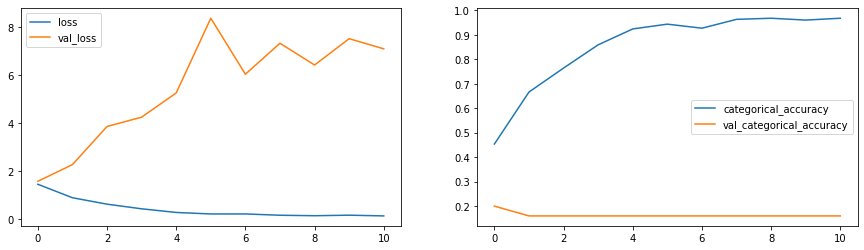

In [ ]:
plot(history_model1)

**Observation: ** Model is clearly overfitting and there was an early stopping which means there was no improvement and needs to be modified

## Model 2  
### Adding dropout layers - Batch Size = 20 and No. of Epochs = 25

In [ ]:
conv_3d2=ModelConv3D1()
conv_3d2.initialize_path(project_folder)
conv_3d2.initialize_image_properties(image_height=100,image_width=100)
conv_3d2.initialize_hyperparams(frames_to_sample=20,batch_size=20,num_epochs=25)
conv_3d2_model=conv_3d2.define_model(dense_neurons=256,dropout=0.5)
conv_3d2_model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_33 (Conv3D)           (None, 20, 100, 100, 16)  1312      
_________________________________________________________________
activation_33 (Activation)   (None, 20, 100, 100, 16)  0         
_________________________________________________________________
batch_normalization_47 (Batc (None, 20, 100, 100, 16)  64        
_________________________________________________________________
max_pooling3d_33 (MaxPooling (None, 10, 50, 50, 16)    0         
_________________________________________________________________
conv3d_34 (Conv3D)           (None, 10, 50, 50, 32)    13856     
_________________________________________________________________
activation_34 (Activation)   (None, 10, 50, 50, 32)    0         
_________________________________________________________________
batch_normalization_48 (Batc (None, 10, 50, 50, 32)   

In [ ]:
print("Total Params:", conv_3d2_model.count_params())
history_model2=conv_3d2.train_model(conv_3d2_model,augment_data=True)

Total Params: 1541829
Epoch 1/25
34/34 [==============================] - 121s 4s/step - loss: 1.9117 - categorical_accuracy: 0.3748 - val_loss: 2.4290 - val_categorical_accuracy: 0.1600

Epoch 00001: val_loss improved from inf to 2.42899, saving model to model_init_2022-02-0714_52_21.939098/model-00001-1.92379-0.37481-2.42899-0.16000.h5
Epoch 2/25
34/34 [==============================] - 117s 3s/step - loss: 1.5957 - categorical_accuracy: 0.4766 - val_loss: 3.6057 - val_categorical_accuracy: 0.1600

Epoch 00002: val_loss did not improve from 2.42899
Epoch 3/25
34/34 [==============================] - 118s 3s/step - loss: 1.2224 - categorical_accuracy: 0.5633 - val_loss: 5.3001 - val_categorical_accuracy: 0.1600

Epoch 00003: val_loss did not improve from 2.42899
Epoch 4/25
34/34 [==============================] - 117s 3s/step - loss: 1.0914 - categorical_accuracy: 0.6312 - val_loss: 6.9451 - val_categorical_accuracy: 0.1600

Epoch 00004: val_loss did not improve from 2.42899
Epoch 5/2

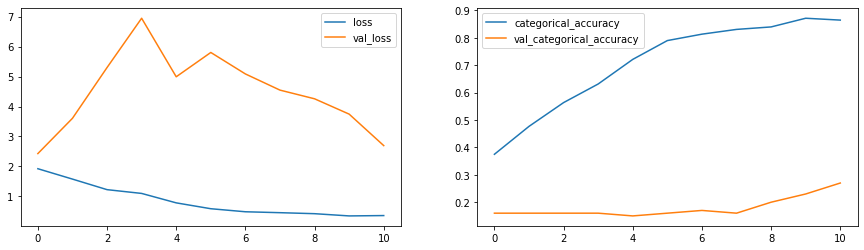

In [ ]:
plot(history_model2)

**Observation:** 

We can see  val_loss did not improve from 2.42899 so earlystopping stops the epoch automatically!! 
- Last Epoch stop on 11/25
- Best weights save automatically. The validation accuracy of 86% and training accuracy of 27% which is clearly overfitting.

Next we will try to reduce the filter size and image resolution and see if get better results. Moreover since we see minor oscillations  in loss, let's try lowering the learning rate to 0.0002

## Model 3 
### Reduce filter size to (2,2,2) and image res to 100 x  100, - Batch Size = 30 and No. of Epochs = 25

In [ ]:
class ModelConv3D3(ModelBuilder):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))
        
        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [ ]:
conv_3d3=ModelConv3D3()
conv_3d3.initialize_path(project_folder)
conv_3d3.initialize_image_properties(image_height=100,image_width=100)
conv_3d3.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=25)
conv_3d3_model=conv_3d3.define_model(filtersize=(2,2,2),dense_neurons=256,dropout=0.5)
conv_3d3_model.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_45 (Conv3D)           (None, 16, 100, 100, 16)  400       
_________________________________________________________________
activation_45 (Activation)   (None, 16, 100, 100, 16)  0         
_________________________________________________________________
batch_normalization_65 (Batc (None, 16, 100, 100, 16)  64        
_________________________________________________________________
max_pooling3d_45 (MaxPooling (None, 8, 50, 50, 16)     0         
_________________________________________________________________
conv3d_46 (Conv3D)           (None, 8, 50, 50, 32)     4128      
_________________________________________________________________
activation_46 (Activation)   (None, 8, 50, 50, 32)     0         
_________________________________________________________________
batch_normalization_66 (Batc (None, 8, 50, 50, 32)   

In [ ]:
print("Total Params:", conv_3d3_model.count_params())
history_model3=conv_3d3.train_model(conv_3d3_model,augment_data=True)

Total Params: 1336629
Epoch 1/25
34/34 [==============================] - 97s 3s/step - loss: 2.2499 - categorical_accuracy: 0.3122 - val_loss: 1.7134 - val_categorical_accuracy: 0.1600

Epoch 00001: val_loss improved from inf to 1.71343, saving model to model_init_2022-02-0716_46_12.051353/model-00001-2.24250-0.31222-1.71343-0.16000.h5
Epoch 2/25
34/34 [==============================] - 95s 3s/step - loss: 1.5502 - categorical_accuracy: 0.4819 - val_loss: 3.3987 - val_categorical_accuracy: 0.1600

Epoch 00002: val_loss did not improve from 1.71343
Epoch 3/25
34/34 [==============================] - 95s 3s/step - loss: 1.3610 - categorical_accuracy: 0.5505 - val_loss: 6.0399 - val_categorical_accuracy: 0.1600

Epoch 00003: val_loss did not improve from 1.71343
Epoch 4/25
34/34 [==============================] - 95s 3s/step - loss: 1.2276 - categorical_accuracy: 0.5882 - val_loss: 6.7471 - val_categorical_accuracy: 0.1600

Epoch 00004: val_loss did not improve from 1.71343
Epoch 5/25
34

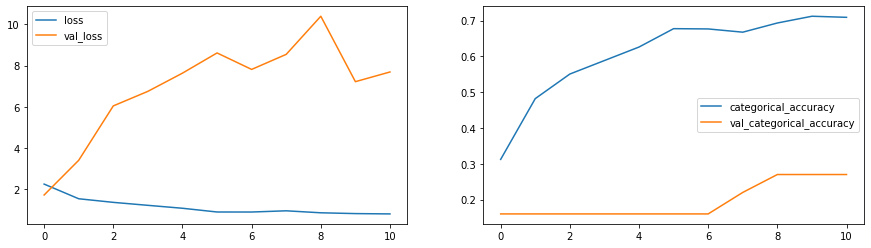

In [ ]:
plot(history_model3)

**Observation:**

Model has a  best validation accuracy of 70% and training accuracy of  27% which is again overfitting. Let's trying adding more layers




## Model 4 - 
### Reducing image size to 96 x 96 , Adding more layers - Batch Size = 20 and No. of Epochs = 25

In [ ]:
class ModelConv3D4(ModelBuilder):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [ ]:
conv_3d4=ModelConv3D4()
conv_3d4.initialize_path(project_folder)
conv_3d4.initialize_image_properties(image_height=96,image_width=96)
conv_3d4.initialize_hyperparams(frames_to_sample=16,batch_size=15,num_epochs=25)
conv_3d4_model=conv_3d4.define_model(filtersize=(3,3,3),dense_neurons=256,dropout=0.5)
conv_3d4_model.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_57 (Conv3D)           (None, 16, 96, 96, 16)    1312      
_________________________________________________________________
activation_57 (Activation)   (None, 16, 96, 96, 16)    0         
_________________________________________________________________
batch_normalization_81 (Batc (None, 16, 96, 96, 16)    64        
_________________________________________________________________
conv3d_58 (Conv3D)           (None, 16, 96, 96, 16)    6928      
_________________________________________________________________
activation_58 (Activation)   (None, 16, 96, 96, 16)    0         
_________________________________________________________________
batch_normalization_82 (Batc (None, 16, 96, 96, 16)    64        
_________________________________________________________________
max_pooling3d_53 (MaxPooling (None, 8, 48, 48, 16)   

In [ ]:
print("Total Params:", conv_3d4_model.count_params())
history_model4=conv_3d4.train_model(conv_3d4_model,augment_data=True)

Total Params: 2130549
Epoch 1/25
45/45 [==============================] - 99s 2s/step - loss: 1.9549 - categorical_accuracy: 0.3635 - val_loss: 2.0963 - val_categorical_accuracy: 0.3200

Epoch 00001: val_loss improved from inf to 2.09632, saving model to model_init_2022-02-0717_36_51.968440/model-00001-1.96075-0.36350-2.09632-0.32000.h5
Epoch 2/25
45/45 [==============================] - 94s 2s/step - loss: 1.5194 - categorical_accuracy: 0.4766 - val_loss: 2.8543 - val_categorical_accuracy: 0.2100

Epoch 00002: val_loss did not improve from 2.09632
Epoch 3/25
45/45 [==============================] - 97s 2s/step - loss: 1.3391 - categorical_accuracy: 0.5324 - val_loss: 3.4078 - val_categorical_accuracy: 0.2100

Epoch 00003: val_loss did not improve from 2.09632
Epoch 4/25
45/45 [==============================] - 96s 2s/step - loss: 1.0790 - categorical_accuracy: 0.5845 - val_loss: 3.9257 - val_categorical_accuracy: 0.2100

Epoch 00004: val_loss did not improve from 2.09632
Epoch 5/25
45

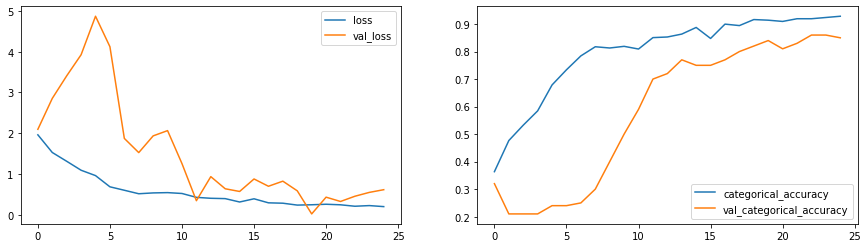

In [ ]:
plot(history_model4)

**Observation**

We are seeing a huge improvement by reducing the image size to 96 x 96. A training score of 92% and validation score of 85% which means the model is generaling well.  Let's try adding dropouts at the convolution layers

## Model 5 
### Adding dropout at convolution layers

In [ ]:
class ModelConv3D5(ModelBuilder):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [ ]:
conv_3d5=ModelConv3D5()
conv_3d5.initialize_path(project_folder)
conv_3d5.initialize_image_properties(image_height=96,image_width=96)
conv_3d5.initialize_hyperparams(frames_to_sample=16,batch_size=15,num_epochs=15)
conv_3d5_model=conv_3d5.define_model(filtersize=(3,3,3),dense_neurons=256,dropout=0.25)
conv_3d5_model.summary()

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_81 (Conv3D)           (None, 16, 96, 96, 16)    1312      
_________________________________________________________________
activation_81 (Activation)   (None, 16, 96, 96, 16)    0         
_________________________________________________________________
batch_normalization_113 (Bat (None, 16, 96, 96, 16)    64        
_________________________________________________________________
conv3d_82 (Conv3D)           (None, 16, 96, 96, 16)    6928      
_________________________________________________________________
activation_82 (Activation)   (None, 16, 96, 96, 16)    0         
_________________________________________________________________
batch_normalization_114 (Bat (None, 16, 96, 96, 16)    64        
_________________________________________________________________
max_pooling3d_69 (MaxPooling (None, 8, 48, 48, 16)   

In [ ]:
print("Total Params:", conv_3d5_model.count_params())
history_model5=conv_3d5.train_model(conv_3d5_model,augment_data=True)

Total Params: 2130549
Epoch 1/15
45/45 [==============================] - 101s 2s/step - loss: 1.7745 - categorical_accuracy: 0.3824 - val_loss: 1.8215 - val_categorical_accuracy: 0.2300

Epoch 00001: val_loss improved from inf to 1.82146, saving model to model_init_2022-02-0720_38_59.686454/model-00001-1.78943-0.38235-1.82146-0.23000.h5
Epoch 2/15
45/45 [==============================] - 100s 2s/step - loss: 1.1129 - categorical_accuracy: 0.5958 - val_loss: 3.2898 - val_categorical_accuracy: 0.2100

Epoch 00002: val_loss did not improve from 1.82146
Epoch 3/15
45/45 [==============================] - 99s 2s/step - loss: 0.9421 - categorical_accuracy: 0.6659 - val_loss: 3.9290 - val_categorical_accuracy: 0.2100

Epoch 00003: val_loss did not improve from 1.82146
Epoch 4/15
45/45 [==============================] - 99s 2s/step - loss: 0.7833 - categorical_accuracy: 0.7104 - val_loss: 2.8161 - val_categorical_accuracy: 0.2500

Epoch 00004: val_loss did not improve from 1.82146
Epoch 5/15


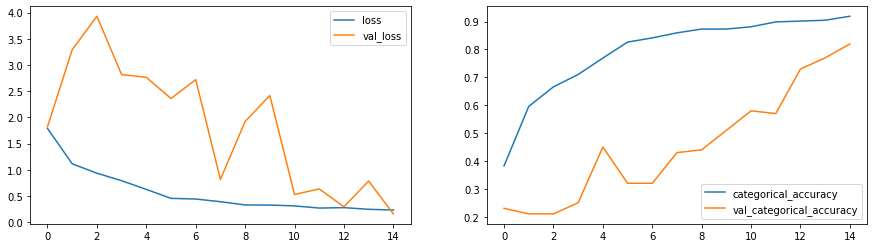

In [ ]:
plot(history_model5)

**Observation: ** The model has a good training score (92% ) vs  validation score (82%). Adding dropouts has further reduced validation score but the model seem to generalise well

All the experimental models above have more than 1 million parameters. Let's try to reduce the model size and see the performance

## Model 6 
### Reducing the number of parameters

In [ ]:
class ModelConv3D6(ModelBuilder):
    
    def define_model(self,dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, (3, 3, 3), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [ ]:
conv_3d6=ModelConv3D6()
conv_3d6.initialize_path(project_folder)
conv_3d6.initialize_image_properties(image_height=96,image_width=96)
conv_3d6.initialize_hyperparams(frames_to_sample=16,batch_size=15,num_epochs=20)
conv_3d6_model=conv_3d6.define_model(dense_neurons=128,dropout=0.25)
conv_3d6_model.summary()

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_89 (Conv3D)           (None, 16, 96, 96, 16)    1312      
_________________________________________________________________
activation_89 (Activation)   (None, 16, 96, 96, 16)    0         
_________________________________________________________________
batch_normalization_123 (Bat (None, 16, 96, 96, 16)    64        
_________________________________________________________________
max_pooling3d_73 (MaxPooling (None, 8, 48, 48, 16)     0         
_________________________________________________________________
conv3d_90 (Conv3D)           (None, 8, 48, 48, 32)     4128      
_________________________________________________________________
activation_90 (Activation)   (None, 8, 48, 48, 32)     0         
_________________________________________________________________
batch_normalization_124 (Bat (None, 8, 48, 48, 32)   

In [ ]:
print("Total Params:", conv_3d6_model.count_params())
history_model6=conv_3d6.train_model(conv_3d6_model,augment_data=True)

Total Params: 696645
Epoch 1/20
45/45 [==============================] - 101s 2s/step - loss: 1.6559 - categorical_accuracy: 0.4020 - val_loss: 3.6440 - val_categorical_accuracy: 0.1600

Epoch 00001: val_loss improved from inf to 3.64399, saving model to model_init_2022-02-0721_05_26.990359/model-00001-1.63566-0.40196-3.64399-0.16000.h5
Epoch 2/20
45/45 [==============================] - 100s 2s/step - loss: 1.0808 - categorical_accuracy: 0.5762 - val_loss: 5.3136 - val_categorical_accuracy: 0.1600

Epoch 00002: val_loss did not improve from 3.64399
Epoch 3/20
45/45 [==============================] - 100s 2s/step - loss: 0.8539 - categorical_accuracy: 0.6742 - val_loss: 8.0763 - val_categorical_accuracy: 0.1600

Epoch 00003: val_loss did not improve from 3.64399
Epoch 4/20
45/45 [==============================] - 101s 2s/step - loss: 0.7582 - categorical_accuracy: 0.7217 - val_loss: 7.9711 - val_categorical_accuracy: 0.1600

Epoch 00004: val_loss did not improve from 3.64399
Epoch 5/20

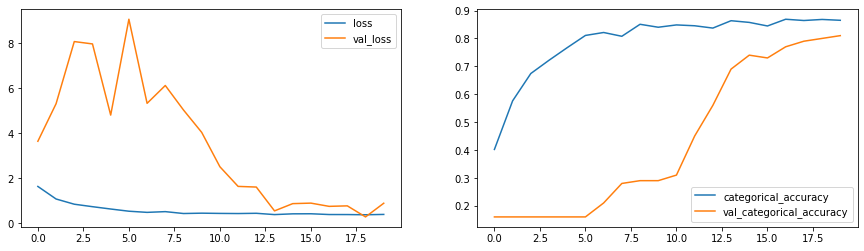

In [ ]:
plot(history_model6)

**Observation** For the above low memory foot print model, we get a validation accuracy of 81% which a little lower than the previous models score but we are losing only 1% of the validation score with a reduction of (2130549-696645=1433904 parameters) or 60% parameter reduction which very good)

## Model 7 
- Reducing the number of parameters again

In [ ]:
class ModelConv3D7(ModelBuilder):
    
    def define_model(self,dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, (3, 3, 3), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (3, 3, 3), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [ ]:
conv_3d7=ModelConv3D7()
conv_3d7.initialize_path(project_folder)
conv_3d7.initialize_image_properties(image_height=96,image_width=96)
conv_3d7.initialize_hyperparams(frames_to_sample=16,batch_size=15,num_epochs=25)
conv_3d7_model=conv_3d7.define_model(dense_neurons=64,dropout=0.25)
conv_3d7_model.summary()

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_93 (Conv3D)           (None, 16, 96, 96, 16)    1312      
_________________________________________________________________
activation_93 (Activation)   (None, 16, 96, 96, 16)    0         
_________________________________________________________________
batch_normalization_129 (Bat (None, 16, 96, 96, 16)    64        
_________________________________________________________________
max_pooling3d_77 (MaxPooling (None, 8, 48, 48, 16)     0         
_________________________________________________________________
conv3d_94 (Conv3D)           (None, 8, 48, 48, 32)     13856     
_________________________________________________________________
activation_94 (Activation)   (None, 8, 48, 48, 32)     0         
_________________________________________________________________
batch_normalization_130 (Bat (None, 8, 48, 48, 32)   

In [ ]:
print("Total Params:", conv_3d7_model.count_params())
history_model7=conv_3d7.train_model(conv_3d7_model,augment_data=True)

Total Params: 398213
Epoch 1/25
45/45 [==============================] - 102s 2s/step - loss: 1.7796 - categorical_accuracy: 0.3560 - val_loss: 1.9700 - val_categorical_accuracy: 0.1600

Epoch 00001: val_loss improved from inf to 1.97004, saving model to model_init_2022-02-0723_20_39.675699/model-00001-1.78175-0.35596-1.97004-0.16000.h5
Epoch 2/25
45/45 [==============================] - 100s 2s/step - loss: 1.2961 - categorical_accuracy: 0.4834 - val_loss: 2.5476 - val_categorical_accuracy: 0.1600

Epoch 00002: val_loss did not improve from 1.97004
Epoch 3/25
45/45 [==============================] - 100s 2s/step - loss: 1.1602 - categorical_accuracy: 0.5581 - val_loss: 4.1514 - val_categorical_accuracy: 0.1600

Epoch 00003: val_loss did not improve from 1.97004
Epoch 4/25
45/45 [==============================] - 101s 2s/step - loss: 1.0359 - categorical_accuracy: 0.6048 - val_loss: 6.3443 - val_categorical_accuracy: 0.1700

Epoch 00004: val_loss did not improve from 1.97004
Epoch 5/25

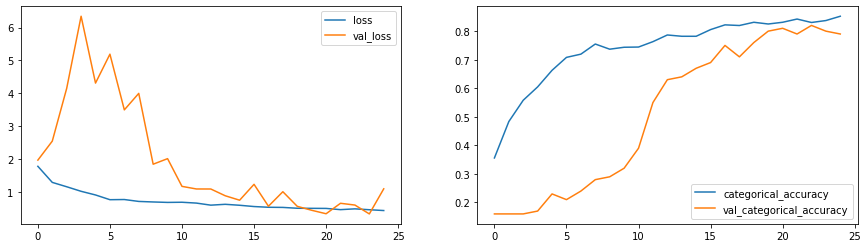

In [ ]:
plot(history_model7)

**Observation**

For the above low memory foot print model the training score of 85% and best validation accuracy of 79% which is improvement over the previous model and it seems to fit well.

## Model 8 - CNN- LSTM Model

In [ ]:
class RNNCNN1(ModelBuilder):
    
    def define_model(self,lstm_cells=64,dense_neurons=64,dropout=0.25):

        model = Sequential()

        model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                                  input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(256, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        #model.add(TimeDistributed(Conv2D(512, (2, 2) , padding='valid', activation='relu')))
       # model.add(TimeDistributed(BatchNormalization()))
       # model.add(TimeDistributed(MaxPooling2D((2, 2))))

        model.add(TimeDistributed(Flatten()))


        model.add(LSTM(lstm_cells))
        model.add(Dropout(dropout))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))
        
        model.add(Dense(self.num_classes, activation='softmax'))
        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [ ]:
rnn_cnn1=RNNCNN1()
rnn_cnn1.initialize_path(project_folder)
rnn_cnn1.initialize_image_properties(image_height=96,image_width=96)
rnn_cnn1.initialize_hyperparams(frames_to_sample=18,batch_size=15,num_epochs=20)
rnn_cnn1_model=rnn_cnn1.define_model(lstm_cells=128,dense_neurons=128,dropout=0.25)
rnn_cnn1_model.summary()

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_1 (TimeDist (None, 18, 96, 96, 16)    448       
_________________________________________________________________
time_distributed_2 (TimeDist (None, 18, 96, 96, 16)    64        
_________________________________________________________________
time_distributed_3 (TimeDist (None, 18, 48, 48, 16)    0         
_________________________________________________________________
time_distributed_4 (TimeDist (None, 18, 48, 48, 32)    4640      
_________________________________________________________________
time_distributed_5 (TimeDist (None, 18, 48, 48, 32)    128       
_________________________________________________________________
time_distributed_6 (TimeDist (None, 18, 24, 24, 32)    0         
_________________________________________________________________
time_distributed_7 (TimeDist (None, 18, 24, 24, 64)  

In [ ]:
print("Total Params:", rnn_cnn1_model.count_params())
history_model8=rnn_cnn1.train_model(rnn_cnn1_model,augment_data=True)

Total Params: 1657445
Epoch 1/20
45/45 [==============================] - 119s 3s/step - loss: 1.3666 - categorical_accuracy: 0.4276 - val_loss: 2.1714 - val_categorical_accuracy: 0.1600

Epoch 00001: val_loss improved from inf to 2.17142, saving model to model_init_2022-02-0800_04_20.822565/model-00001-1.37684-0.42760-2.17142-0.16000.h5
Epoch 2/20
45/45 [==============================] - 111s 2s/step - loss: 1.0809 - categorical_accuracy: 0.5965 - val_loss: 2.7677 - val_categorical_accuracy: 0.2700

Epoch 00002: val_loss did not improve from 2.17142
Epoch 3/20
45/45 [==============================] - 112s 2s/step - loss: 0.7923 - categorical_accuracy: 0.7127 - val_loss: 1.8376 - val_categorical_accuracy: 0.1600

Epoch 00003: val_loss improved from 2.17142 to 1.83760, saving model to model_init_2022-02-0800_04_20.822565/model-00003-0.78614-0.71267-1.83760-0.16000.h5
Epoch 4/20
45/45 [==============================] - 114s 3s/step - loss: 0.7195 - categorical_accuracy: 0.7428 - val_loss

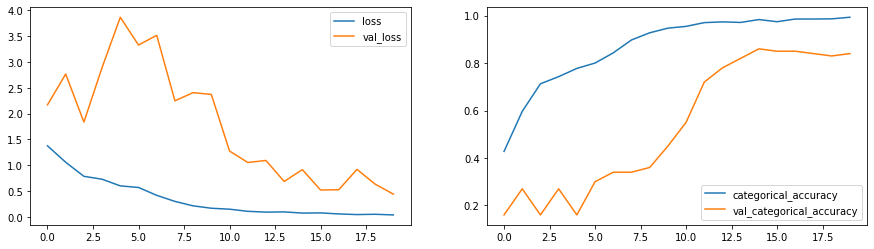

In [ ]:
plot(history_model8)

**Observation**

For CNN - LSTM model we get a good validation accuracy of 85% on a training score if 98%

As we see more cases of overfitting, lets augment the data with ***slight rotation*** as well and run the same set of models again

## Data augmentation

In [ ]:
class ModelBuilderMoreAugmentation(metaclass= abc.ABCMeta):
    
    def initialize_path(self,project_folder):
        self.train_doc = np.random.permutation(open(project_folder + '/' + 'train.csv').readlines())
        self.val_doc = np.random.permutation(open(project_folder + '/' + 'val.csv').readlines())
        self.train_path = project_folder + '/' + 'train'
        self.val_path =  project_folder + '/' + 'val'
        self.num_train_sequences = len(self.train_doc)
        self.num_val_sequences = len(self.val_doc)
        
    def initialize_image_properties(self,image_height=100,image_width=100):
        self.image_height=image_height
        self.image_width=image_width
        self.channels=3
        self.num_classes=5
        self.total_frames=30
          
    def initialize_hyperparams(self,frames_to_sample=30,batch_size=20,num_epochs=20):
        self.frames_to_sample=frames_to_sample
        self.batch_size=batch_size
        self.num_epochs=num_epochs
        
        
    def generator(self,source_path, folder_list, augment=False):
        img_idx = np.round(np.linspace(0,self.total_frames-1,self.frames_to_sample)).astype(int)
        batch_size=self.batch_size
        while True:
            t = np.random.permutation(folder_list)
            num_batches = len(t)//batch_size
        
            for batch in range(num_batches): 
                batch_data, batch_labels= self.one_batch_data(source_path,t,batch,batch_size,img_idx,augment)
                yield batch_data, batch_labels 

            remaining_seq=len(t)%batch_size
        
            if (remaining_seq != 0):
                batch_data, batch_labels= self.one_batch_data(source_path,t,num_batches,batch_size,img_idx,augment,remaining_seq)
                yield batch_data, batch_labels 
    
    
    def one_batch_data(self,source_path,t,batch,batch_size,img_idx,augment,remaining_seq=0):
    
        seq_len = remaining_seq if remaining_seq else batch_size
    
        batch_data = np.zeros((seq_len,len(img_idx),self.image_height,self.image_width,self.channels)) 
        batch_labels = np.zeros((seq_len,self.num_classes)) 
    
        if (augment): batch_data_aug = np.zeros((seq_len,len(img_idx),self.image_height,self.image_width,self.channels))

        
        for folder in range(seq_len): 
            imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) 
            for idx,item in enumerate(img_idx): 
                image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                image_resized=imresize(image,(self.image_height,self.image_width,3))
            

                batch_data[folder,idx,:,:,0] = (image_resized[:,:,0])/255
                batch_data[folder,idx,:,:,1] = (image_resized[:,:,1])/255
                batch_data[folder,idx,:,:,2] = (image_resized[:,:,2])/255
            
                if (augment):
                    shifted = cv2.warpAffine(image, 
                                             np.float32([[1, 0, np.random.randint(-30,30)],[0, 1, np.random.randint(-30,30)]]), 
                                            (image.shape[1], image.shape[0]))
                    
                    gray = cv2.cvtColor(shifted,cv2.COLOR_BGR2GRAY)

                    x0, y0 = np.argwhere(gray > 0).min(axis=0)
                    x1, y1 = np.argwhere(gray > 0).max(axis=0) 
                    
                    cropped=shifted[x0:x1,y0:y1,:]
                    
                    image_resized=imresize(cropped,(self.image_height,self.image_width,3))
                    
                    M = cv2.getRotationMatrix2D((self.image_width//2,self.image_height//2),
                                                np.random.randint(-10,10), 1.0)
                    rotated = cv2.warpAffine(image_resized, M, (self.image_width, self.image_height))
                    
                    #shifted = cv2.warpAffine(image_resized, 
                    #                        np.float32([[1, 0, np.random.randint(-3,3)],[0, 1, np.random.randint(-3,3)]]), 
                    #                        (image_resized.shape[1], image_resized.shape[0]))
            
                    batch_data_aug[folder,idx,:,:,0] = (rotated[:,:,0])/255
                    batch_data_aug[folder,idx,:,:,1] = (rotated[:,:,1])/255
                    batch_data_aug[folder,idx,:,:,2] = (rotated[:,:,2])/255
                
            
            batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            
    
        if (augment):
            batch_data=np.concatenate([batch_data,batch_data_aug])
            batch_labels=np.concatenate([batch_labels,batch_labels])

        
        return(batch_data,batch_labels)
    
    
    def train_model(self, model, augment_data=False):
        train_generator = self.generator(self.train_path, self.train_doc,augment=augment_data)
        val_generator = self.generator(self.val_path, self.val_doc)

        model_name = 'model_init' + '_' + str(datetime.datetime.now()).replace(' ','').replace(':','_') + '/'
    
        if not os.path.exists(model_name):
            os.mkdir(model_name)
        
        filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

        checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)
        LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)
        callbacks_list = [checkpoint, LR]

        if (self.num_train_sequences%self.batch_size) == 0:
            steps_per_epoch = int(self.num_train_sequences/self.batch_size)
        else:
            steps_per_epoch = (self.num_train_sequences//self.batch_size) + 1

        if (self.num_val_sequences%self.batch_size) == 0:
            validation_steps = int(self.num_val_sequences/self.batch_size)
        else:
            validation_steps = (self.num_val_sequences//self.batch_size) + 1
    
        history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=self.num_epochs, verbose=1, 
                            callbacks=callbacks_list, validation_data=val_generator, 
                            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
        return history

        
    @abc.abstractmethod
    def define_model(self):
        pass
    
    

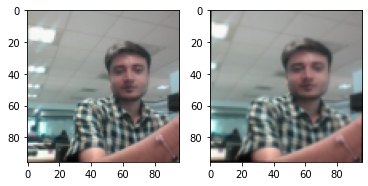

In [ ]:
class Test(ModelBuilderMoreAugmentation):
    def define_model(self):
        pass

test_generator=Test()
test_generator.initialize_path(project_folder)
test_generator.initialize_image_properties(image_height=96,image_width=96)
test_generator.initialize_hyperparams(frames_to_sample=30,batch_size=3,num_epochs=1)

g=test_generator.generator(test_generator.val_path,test_generator.val_doc,augment=True)
batch_data, batch_labels=next(g)
fig, axes = plt.subplots(nrows=1, ncols=2)
axes[0].imshow(batch_data[0,29,:,:,:])   
axes[1].imshow(batch_data[3,29,:,:,:])   

## Model 9 with Augmentation
(3,3,3) Filter & 160x160 Image resolution - similar to Model 2

In [ ]:
class ModelConv3D9(ModelBuilderMoreAugmentation):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [ ]:
conv_3d9=ModelConv3D9()
conv_3d9.initialize_path(project_folder)
conv_3d9.initialize_image_properties(image_height=96,image_width=96)
conv_3d9.initialize_hyperparams(frames_to_sample=20,batch_size=15,num_epochs=20)
conv_3d9_model=conv_3d9.define_model(dense_neurons=256,dropout=0.5)
conv_3d9_model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 20, 96, 96, 16)    1312      
_________________________________________________________________
activation_1 (Activation)    (None, 20, 96, 96, 16)    0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 20, 96, 96, 16)    64        
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 10, 48, 48, 16)    0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 10, 48, 48, 32)    13856     
_________________________________________________________________
activation_2 (Activation)    (None, 10, 48, 48, 32)    0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 10, 48, 48, 32)   

In [ ]:
print("Total Params:", conv_3d9_model.count_params())
history_model9=conv_3d9.train_model(conv_3d9_model,augment_data=True)

Total Params: 1541829
Epoch 1/20
45/45 [==============================] - 123s 3s/step - loss: 2.1971 - categorical_accuracy: 0.3220 - val_loss: 2.1900 - val_categorical_accuracy: 0.1600

Epoch 00001: saving model to model_init_2022-02-0819_48_51.395684/model-00001-2.18318-0.32202-2.19000-0.16000.h5
Epoch 2/20
45/45 [==============================] - 108s 2s/step - loss: 1.6753 - categorical_accuracy: 0.4193 - val_loss: 2.4389 - val_categorical_accuracy: 0.1600

Epoch 00002: saving model to model_init_2022-02-0819_48_51.395684/model-00002-1.65668-0.41931-2.43890-0.16000.h5
Epoch 3/20
45/45 [==============================] - 108s 2s/step - loss: 1.5098 - categorical_accuracy: 0.4872 - val_loss: 4.1249 - val_categorical_accuracy: 0.2400

Epoch 00003: saving model to model_init_2022-02-0819_48_51.395684/model-00003-1.50381-0.48718-4.12488-0.24000.h5
Epoch 4/20
45/45 [==============================] - 109s 2s/step - loss: 1.3090 - categorical_accuracy: 0.5551 - val_loss: 3.5359 - val_categ

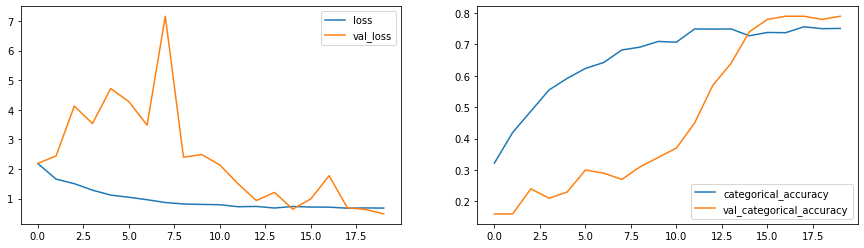

In [ ]:
plot(history_model9)

**Observation**

The model shows a fit with a training score of 75% and valdidation score of 79% which shouldn't ideally be the case and the model overfits.

## Model 10 with Augmentation
### (2,2,2) Filter  & 96 X 96 Image resolution - similar to Model 3

In [ ]:
class ModelConv3D10(ModelBuilderMoreAugmentation):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [ ]:
conv_3d10=ModelConv3D10()
conv_3d10.initialize_path(project_folder)
conv_3d10.initialize_image_properties(image_height=96,image_width=96)
conv_3d10.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=25)
conv_3d10_model=conv_3d10.define_model(filtersize=(2,2,2),dense_neurons=256,dropout=0.5)
conv_3d10_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_5 (Conv3D)            (None, 16, 96, 96, 16)    400       
_________________________________________________________________
activation_5 (Activation)    (None, 16, 96, 96, 16)    0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 16, 96, 96, 16)    64        
_________________________________________________________________
max_pooling3d_5 (MaxPooling3 (None, 8, 48, 48, 16)     0         
_________________________________________________________________
conv3d_6 (Conv3D)            (None, 8, 48, 48, 32)     4128      
_________________________________________________________________
activation_6 (Activation)    (None, 8, 48, 48, 32)     0         
_________________________________________________________________
batch_normalization_8 (Batch (None, 8, 48, 48, 32)    

In [ ]:
print("Total Params:", conv_3d10_model.count_params())
history_model10=conv_3d10.train_model(conv_3d10_model,augment_data=True)

Total Params: 1336629
Epoch 1/25
34/34 [==============================] - 92s 3s/step - loss: 2.1079 - categorical_accuracy: 0.3265 - val_loss: 2.0812 - val_categorical_accuracy: 0.1600

Epoch 00001: saving model to model_init_2022-02-0820_25_42.265197/model-00001-2.09046-0.32655-2.08116-0.16000.h5
Epoch 2/25
34/34 [==============================] - 86s 3s/step - loss: 1.5080 - categorical_accuracy: 0.5030 - val_loss: 3.6694 - val_categorical_accuracy: 0.1600

Epoch 00002: saving model to model_init_2022-02-0820_25_42.265197/model-00002-1.50472-0.50302-3.66945-0.16000.h5
Epoch 3/25
34/34 [==============================] - 87s 3s/step - loss: 1.1795 - categorical_accuracy: 0.5875 - val_loss: 4.8283 - val_categorical_accuracy: 0.1600

Epoch 00003: saving model to model_init_2022-02-0820_25_42.265197/model-00003-1.19280-0.58748-4.82828-0.16000.h5
Epoch 4/25
34/34 [==============================] - 87s 3s/step - loss: 1.0493 - categorical_accuracy: 0.6244 - val_loss: 6.0263 - val_categoric

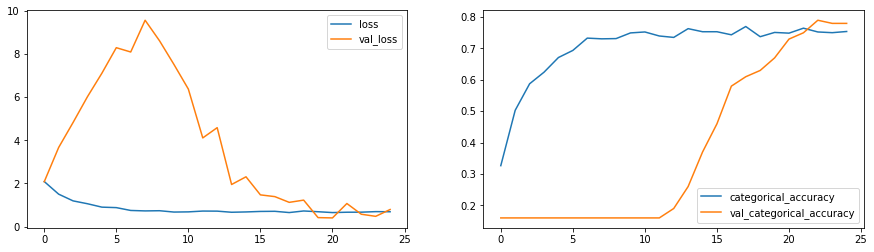

In [ ]:
plot(history_model10)

**Observation**

The model again shows a fit with a training score of 75% and valdidation score of 78% similar to previous model and is an overfit again

## Model 11 with Augmentation
### Adding more layers - Similar to model 4

In [ ]:
class ModelConv3D11(ModelBuilderMoreAugmentation):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [ ]:
conv_3d11=ModelConv3D11()
conv_3d11.initialize_path(project_folder)
conv_3d11.initialize_image_properties(image_height=96,image_width=96)
conv_3d11.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=25)
conv_3d11_model=conv_3d11.define_model(filtersize=(3,3,3),dense_neurons=256,dropout=0.5)
conv_3d11_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_17 (Conv3D)           (None, 16, 96, 96, 16)    1312      
_________________________________________________________________
activation_17 (Activation)   (None, 16, 96, 96, 16)    0         
_________________________________________________________________
batch_normalization_23 (Batc (None, 16, 96, 96, 16)    64        
_________________________________________________________________
conv3d_18 (Conv3D)           (None, 16, 96, 96, 16)    6928      
_________________________________________________________________
activation_18 (Activation)   (None, 16, 96, 96, 16)    0         
_________________________________________________________________
batch_normalization_24 (Batc (None, 16, 96, 96, 16)    64        
_________________________________________________________________
max_pooling3d_13 (MaxPooling (None, 8, 48, 48, 16)    

In [ ]:
print("Total Params:", conv_3d11_model.count_params())
history_model11=conv_3d11.train_model(conv_3d11_model,augment_data=True)

Total Params: 2130549
Epoch 1/25
34/34 [==============================] - 98s 3s/step - loss: 2.2136 - categorical_accuracy: 0.3024 - val_loss: 2.1033 - val_categorical_accuracy: 0.2100

Epoch 00001: saving model to model_init_2022-02-0821_19_13.411578/model-00001-2.19845-0.30241-2.10325-0.21000.h5
Epoch 2/25
34/34 [==============================] - 94s 3s/step - loss: 1.6678 - categorical_accuracy: 0.4397 - val_loss: 2.2854 - val_categorical_accuracy: 0.2100

Epoch 00002: saving model to model_init_2022-02-0821_19_13.411578/model-00002-1.64282-0.43967-2.28544-0.21000.h5
Epoch 3/25
34/34 [==============================] - 96s 3s/step - loss: 1.5172 - categorical_accuracy: 0.4902 - val_loss: 2.7311 - val_categorical_accuracy: 0.2100

Epoch 00003: saving model to model_init_2022-02-0821_19_13.411578/model-00003-1.49634-0.49020-2.73112-0.21000.h5
Epoch 4/25
34/34 [==============================] - 93s 3s/step - loss: 1.3208 - categorical_accuracy: 0.5468 - val_loss: 3.9221 - val_categoric

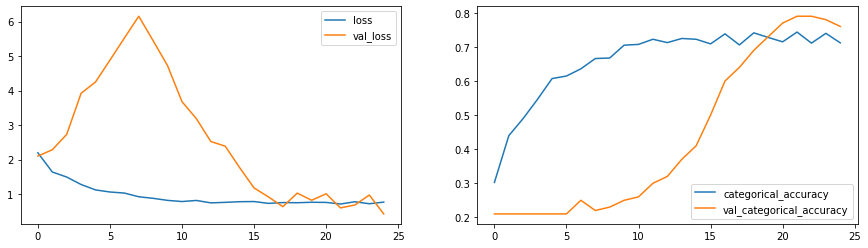

In [ ]:
plot(history_model11)

**Observation**

The model performace has degraded and shows a  fit with a training score of 71% and valdidation score of 76% which is still overfitting

## Model 12 with Augmentation
### Adding dropouts - Similar to Model 5

In [ ]:
class ModelConv3D12(ModelBuilderMoreAugmentation):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [ ]:
conv_3d12=ModelConv3D12()
conv_3d12.initialize_path(project_folder)
conv_3d12.initialize_image_properties(image_height=96,image_width=96)
conv_3d12.initialize_hyperparams(frames_to_sample=16,batch_size=15,num_epochs=25)
conv_3d12_model=conv_3d12.define_model(filtersize=(3,3,3),dense_neurons=256,dropout=0.25)
conv_3d12_model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_25 (Conv3D)           (None, 16, 96, 96, 16)    1312      
_________________________________________________________________
activation_25 (Activation)   (None, 16, 96, 96, 16)    0         
_________________________________________________________________
batch_normalization_33 (Batc (None, 16, 96, 96, 16)    64        
_________________________________________________________________
conv3d_26 (Conv3D)           (None, 16, 96, 96, 16)    6928      
_________________________________________________________________
activation_26 (Activation)   (None, 16, 96, 96, 16)    0         
_________________________________________________________________
batch_normalization_34 (Batc (None, 16, 96, 96, 16)    64        
_________________________________________________________________
max_pooling3d_17 (MaxPooling (None, 8, 48, 48, 16)    

In [ ]:
print("Total Params:", conv_3d12_model.count_params())
history_model12=conv_3d12.train_model(conv_3d12_model,augment_data=True)

Total Params: 2130549
Epoch 1/25
45/45 [==============================] - 97s 2s/step - loss: 1.9642 - categorical_accuracy: 0.3137 - val_loss: 2.9754 - val_categorical_accuracy: 0.2100

Epoch 00001: saving model to model_init_2022-02-0822_20_33.588053/model-00001-1.97475-0.31373-2.97540-0.21000.h5
Epoch 2/25
45/45 [==============================] - 95s 2s/step - loss: 1.7135 - categorical_accuracy: 0.3952 - val_loss: 3.0076 - val_categorical_accuracy: 0.2000

Epoch 00002: saving model to model_init_2022-02-0822_20_33.588053/model-00002-1.71579-0.39517-3.00758-0.20000.h5
Epoch 3/25
45/45 [==============================] - 96s 2s/step - loss: 1.4738 - categorical_accuracy: 0.4668 - val_loss: 2.9426 - val_categorical_accuracy: 0.1600

Epoch 00003: saving model to model_init_2022-02-0822_20_33.588053/model-00003-1.46433-0.46682-2.94256-0.16000.h5
Epoch 4/25
45/45 [==============================] - 94s 2s/step - loss: 1.3332 - categorical_accuracy: 0.4977 - val_loss: 2.5259 - val_categoric

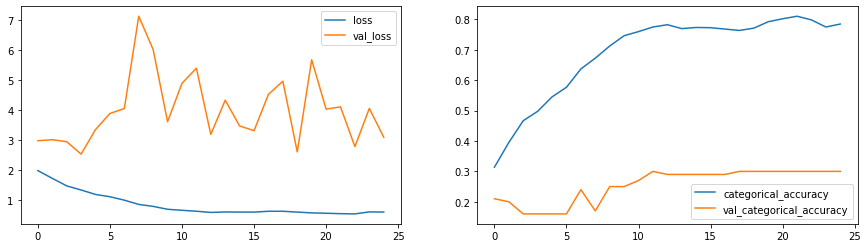

In [ ]:
plot(history_model12)

**Observation**

The model overfits badly with a poor validation score

## Model 13 with Augmentation
### Reducing network parameters - Similar to Model 6

In [ ]:
class ModelConv3D13(ModelBuilderMoreAugmentation):
    
    def define_model(self,dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, (3, 3, 3), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [ ]:
conv_3d13=ModelConv3D13()
conv_3d13.initialize_path(project_folder)
conv_3d13.initialize_image_properties(image_height=100,image_width=100)
conv_3d13.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=25)
conv_3d13_model=conv_3d13.define_model(dense_neurons=128,dropout=0.25)
conv_3d13_model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_33 (Conv3D)           (None, 16, 100, 100, 16)  1312      
_________________________________________________________________
activation_33 (Activation)   (None, 16, 100, 100, 16)  0         
_________________________________________________________________
batch_normalization_43 (Batc (None, 16, 100, 100, 16)  64        
_________________________________________________________________
max_pooling3d_21 (MaxPooling (None, 8, 50, 50, 16)     0         
_________________________________________________________________
conv3d_34 (Conv3D)           (None, 8, 50, 50, 32)     4128      
_________________________________________________________________
activation_34 (Activation)   (None, 8, 50, 50, 32)     0         
_________________________________________________________________
batch_normalization_44 (Batc (None, 8, 50, 50, 32)    

In [ ]:
print("Total Params:", conv_3d13_model.count_params())
history_model13=conv_3d13.train_model(conv_3d13_model,augment_data=True)

Total Params: 696645
Epoch 1/25
34/34 [==============================] - 95s 3s/step - loss: 1.7951 - categorical_accuracy: 0.3499 - val_loss: 1.8195 - val_categorical_accuracy: 0.1600

Epoch 00001: saving model to model_init_2022-02-0823_00_47.454529/model-00001-1.80516-0.34992-1.81952-0.16000.h5
Epoch 2/25
34/34 [==============================] - 93s 3s/step - loss: 1.1564 - categorical_accuracy: 0.5679 - val_loss: 3.4308 - val_categorical_accuracy: 0.1600

Epoch 00002: saving model to model_init_2022-02-0823_00_47.454529/model-00002-1.16667-0.56787-3.43082-0.16000.h5
Epoch 3/25
34/34 [==============================] - 97s 3s/step - loss: 0.9245 - categorical_accuracy: 0.6704 - val_loss: 3.7889 - val_categorical_accuracy: 0.1600

Epoch 00003: saving model to model_init_2022-02-0823_00_47.454529/model-00003-0.90230-0.67044-3.78891-0.16000.h5
Epoch 4/25
34/34 [==============================] - 99s 3s/step - loss: 0.7628 - categorical_accuracy: 0.7195 - val_loss: 4.3971 - val_categorica

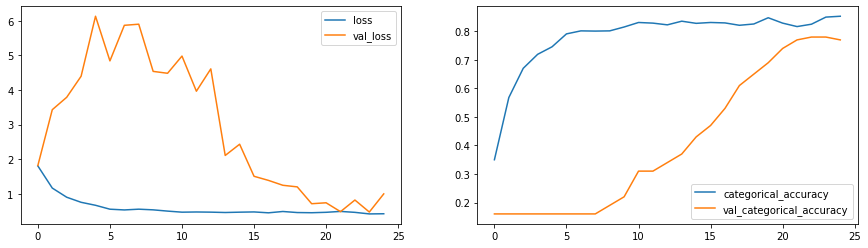

In [ ]:
plot(history_model13)

**Observation**

The model has improved from the overfitting previous models and shows a training score of 85% and validation score of 77 %

## Model 14 with Augmentation
###  Reducing network parameters again - Similar to model 7

In [ ]:
class ModelConv3D14(ModelBuilderMoreAugmentation):
    
    def define_model(self,dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, (3, 3, 3), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (3, 3, 3), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [ ]:
conv_3d14=ModelConv3D14()
conv_3d14.initialize_path(project_folder)
conv_3d14.initialize_image_properties(image_height=96,image_width=96)
conv_3d14.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=25)
conv_3d14_model=conv_3d14.define_model(dense_neurons=64,dropout=0.25)
conv_3d14_model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_41 (Conv3D)           (None, 16, 96, 96, 16)    1312      
_________________________________________________________________
activation_41 (Activation)   (None, 16, 96, 96, 16)    0         
_________________________________________________________________
batch_normalization_55 (Batc (None, 16, 96, 96, 16)    64        
_________________________________________________________________
max_pooling3d_29 (MaxPooling (None, 8, 48, 48, 16)     0         
_________________________________________________________________
conv3d_42 (Conv3D)           (None, 8, 48, 48, 32)     13856     
_________________________________________________________________
activation_42 (Activation)   (None, 8, 48, 48, 32)     0         
_________________________________________________________________
batch_normalization_56 (Batc (None, 8, 48, 48, 32)    

In [ ]:
print("Total Params:", conv_3d14_model.count_params())
history_model14=conv_3d14.train_model(conv_3d14_model,augment_data=True)

Total Params: 398213
Epoch 1/25
34/34 [==============================] - 103s 3s/step - loss: 1.9988 - categorical_accuracy: 0.3084 - val_loss: 1.6516 - val_categorical_accuracy: 0.1600

Epoch 00001: saving model to model_init_2022-02-0900_12_14.288229/model-00001-1.98115-0.30845-1.65160-0.16000.h5
Epoch 2/25
34/34 [==============================] - 99s 3s/step - loss: 1.3752 - categorical_accuracy: 0.4706 - val_loss: 2.1972 - val_categorical_accuracy: 0.1600

Epoch 00002: saving model to model_init_2022-02-0900_12_14.288229/model-00002-1.38250-0.47059-2.19722-0.16000.h5
Epoch 3/25
34/34 [==============================] - 100s 3s/step - loss: 1.2136 - categorical_accuracy: 0.5437 - val_loss: 2.8895 - val_categorical_accuracy: 0.1600

Epoch 00003: saving model to model_init_2022-02-0900_12_14.288229/model-00003-1.19413-0.54374-2.88946-0.16000.h5
Epoch 4/25
34/34 [==============================] - 96s 3s/step - loss: 1.0586 - categorical_accuracy: 0.5980 - val_loss: 3.0677 - val_categori

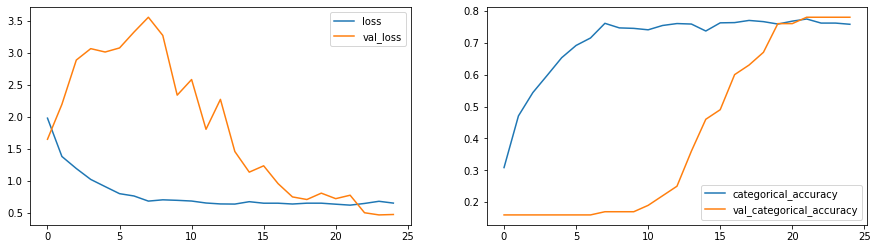

In [ ]:
plot(history_model14)

**Observation**

The model overfits with validation score greater than test score

## Model 15 with Augmentation
### CNN LSTM with GRU - Similar to Model 8

In [ ]:
class RNNCNN2(ModelBuilderMoreAugmentation):
    
    def define_model(self,lstm_cells=64,dense_neurons=64,dropout=0.25):

        model = Sequential()

        model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                                  input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        

        model.add(TimeDistributed(Flatten()))


        model.add(GRU(lstm_cells))
        model.add(Dropout(dropout))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))
        
        model.add(Dense(self.num_classes, activation='softmax'))
        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [ ]:
rnn_cnn2=RNNCNN2()
rnn_cnn2.initialize_path(project_folder)
rnn_cnn2.initialize_image_properties(image_height=96,image_width=96)
rnn_cnn2.initialize_hyperparams(frames_to_sample=18,batch_size=20,num_epochs=20)
rnn_cnn2_model=rnn_cnn2.define_model(lstm_cells=128,dense_neurons=128,dropout=0.25)
rnn_cnn2_model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_1 (TimeDist (None, 18, 96, 96, 16)    448       
_________________________________________________________________
time_distributed_2 (TimeDist (None, 18, 96, 96, 16)    64        
_________________________________________________________________
time_distributed_3 (TimeDist (None, 18, 48, 48, 16)    0         
_________________________________________________________________
time_distributed_4 (TimeDist (None, 18, 48, 48, 32)    4640      
_________________________________________________________________
time_distributed_5 (TimeDist (None, 18, 48, 48, 32)    128       
_________________________________________________________________
time_distributed_6 (TimeDist (None, 18, 24, 24, 32)    0         
_________________________________________________________________
time_distributed_7 (TimeDist (None, 18, 24, 24, 64)   

In [ ]:
print("Total Params:", rnn_cnn2_model.count_params())
history_model15=rnn_cnn2.train_model(rnn_cnn2_model,augment_data=True)

Total Params: 1934565
Epoch 1/20
34/34 [==============================] - 120s 4s/step - loss: 1.4175 - categorical_accuracy: 0.4140 - val_loss: 1.5444 - val_categorical_accuracy: 0.3400

Epoch 00001: saving model to model_init_2022-02-0901_01_50.070943/model-00001-1.40467-0.41403-1.54443-0.34000.h5
Epoch 2/20
34/34 [==============================] - 110s 3s/step - loss: 0.9351 - categorical_accuracy: 0.6342 - val_loss: 1.5048 - val_categorical_accuracy: 0.2100

Epoch 00002: saving model to model_init_2022-02-0901_01_50.070943/model-00002-0.94096-0.63424-1.50483-0.21000.h5
Epoch 3/20
34/34 [==============================] - 114s 3s/step - loss: 0.6817 - categorical_accuracy: 0.7511 - val_loss: 1.8970 - val_categorical_accuracy: 0.2100

Epoch 00003: saving model to model_init_2022-02-0901_01_50.070943/model-00003-0.68995-0.75113-1.89696-0.21000.h5
Epoch 4/20
34/34 [==============================] - 112s 3s/step - loss: 0.5443 - categorical_accuracy: 0.8084 - val_loss: 1.8366 - val_categ

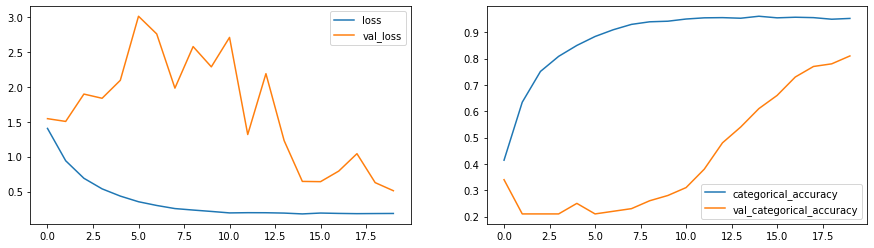

In [ ]:
plot(history_model15)

**Observation**

The model overfits comparatively lesser with a training score of 95% and  validation score of 81%

## Inference
We see that overfitting is considerably high when we do more augmentation. However there is not much improvement on accuracy

# Consolidated Final Models

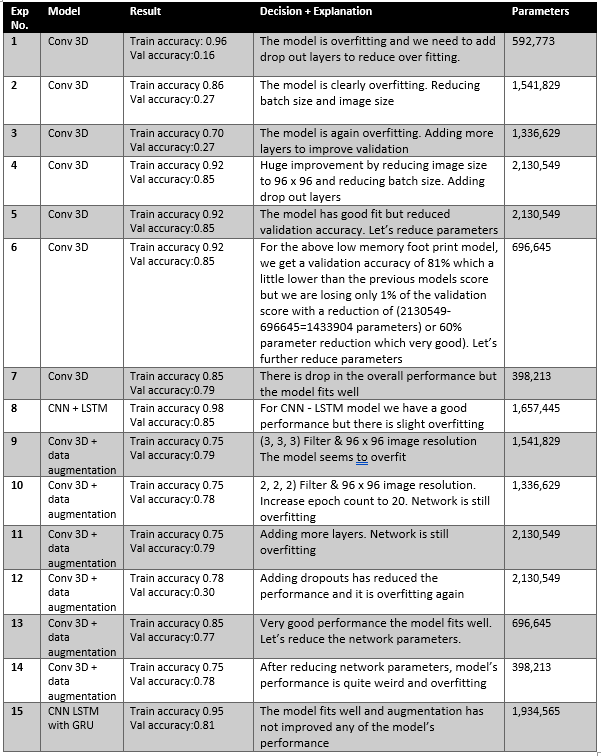

After doing all the experiments, we finalized Model 8 - CNN+LSTM, which performed well.


__Reason:__

__- (Training Accuracy : 98%, Validation Accuracy : 85%)__

__- Number of Parameters(1,657,445)less according to other models performance__

__- Learning rate gradually decreacing after 16 Epoch__


__The best weights of CNN-LSTM: model-00016-0.07692-0.97436-0.52019-0.85000.h5 (19 MB). we considered this weight for model testing.
